In [48]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from minst_read import MnistDataloader
input_path = './'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train_num, y_train_num), (x_test_num, y_test_num) = mnist_dataloader.load_data()

In [49]:
x_train = x_train_num[:50000].reshape(50000,-1).astype(np.float32)
y_train = y_train_num[:50000].reshape(50000,1)

x_val = x_train_num[50000:].reshape(10000,-1).astype(np.float32)
y_val = y_train_num[50000:].reshape(10000,1)

x_test = x_test_num.copy().reshape(10000,-1).astype(np.float32)
y_test = y_test_num.copy().reshape(10000,1)

def plot_number(image):
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

In [50]:
x_train.mean(), x_train.std(), x_train.min()

(33.395157, 78.66619, 0.0)

In [51]:
def normalize(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [52]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalize(x_mean, x_std, x_train)
x_val = normalize(x_mean, x_std, x_val)
x_test = normalize(x_mean, x_std, x_test)

In [53]:
x_train.mean(), x_train.std(), x_train.min()

(-3.1638146e-07, 0.99999934, -0.42451727)

El valor es: [7]


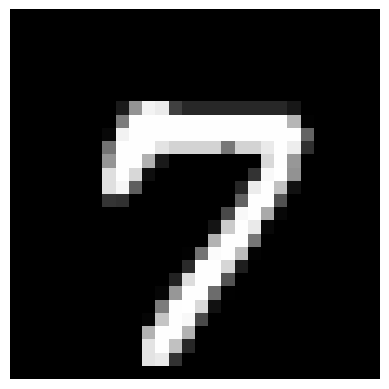

In [54]:
idx = np.random.randint(len(y_test))
print(f'El valor es: {y_test[idx]}')
plot_number(x_test_num[idx])

In [55]:
def create_minibatches(mb_size, x, y, shuffle = True):
    assert x.shape[0] == y.shape[0], 'Diferente tamaño'
    total_data = x.shape[0]
    if shuffle:
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

# Clase linear, ReLU y Squential

In [56]:
class np_tensor(np.ndarray): pass

### Clase linear

In [57]:
class Linear():
    def __init__(self, input_size, output_size):
        '''
        Init parameters utilizando Kaiming He
        '''
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
        self.b = (np.zeros((output_size, 1))).view(np_tensor)
    def __call__(self, X): # esta el foward de la clase lineal
        Z = self.W @ X + self.b
        return Z
    def backward(self, X, Z):
        X.grad = self.W.T @ Z.grad
        self.W.grad = Z.grad @ X.T
        self.b.grad = np.sum(Z.grad, axis = 1, keepdims=True)    

### Class Relu

In [58]:
class ReLU():
    def __call__(self, Z):
        return np.maximum(0, Z)
    def backward(self, Z, A):
        Z.grad = A.grad.copy()
        Z.grad[Z <= 0] = 0

### Class Sequential

In [59]:
class Sequential_layers():
    def __init__(self, layers):
        '''
        layers - lista que contiene objetos de tipo Linear, ReLU
        '''
        self.layers = layers
        self.x = None
        self.outputs = {}
    def __call__(self, X):
        self.x = X 
        self.outputs['l0'] = self.x
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs['l'+str(i)]=self.x
        return self.x
    def backward(self):
        for i in reversed(range(len(self.layers))):
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])
    def update(self, learning_rate = 1e-3):
        for layer in self.layers:
            if isinstance(layer, ReLU): continue
            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad
    def predict(self, X):
        return np.argmax(self.__call__(X))   
    

### Cost function   

In [60]:
def softmaxXEntropy(x, y):
    batch_size = x.shape[1]
    exp_scores = np.exp(x)
    probs = exp_scores / exp_scores.sum(axis = 0)
    preds = probs.copy()
    # Costo
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size
    # Calcular gradientes
    probs[y.squeeze(), np.arange(batch_size)] -= 1 #dl/dx
    x.grad = probs.copy()
    
    return preds, cost

### Loops de entrenamiento

In [61]:

def train(model, epochs, mb_size=128, learning_rate = 1e-3):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores = model(x.T.view(np_tensor))
            _, cost = softmaxXEntropy(scores, y)
            model.backward()
            model.update(learning_rate)
        print(f'costo: {cost}, accuracy: {accuracy(x_val, y_val, mb_size)}')
        
def accuracy(x, y, mb_size):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):
        pred = model(x.T.view(np_tensor))
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())
        total += pred.shape[1]
    return correct/total
        

In [62]:
model = Sequential_layers([Linear(784, 200), ReLU(), Linear(200, 200), ReLU(), Linear(200, 10)])
mb_size = 512
learning_rate = 1e-4
epochs = 20

In [63]:
train(model, epochs, mb_size, learning_rate)

NameError: name 'create_minibatches' is not defined